<a href="https://colab.research.google.com/github/Keehojeong/2020-2-AI/blob/master/20190747_%EA%B8%B0%ED%98%B8%EC%A0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ✔개요

### 👨‍👧‍👦 학번이름
동양미래대학교 컴퓨터정보공학과
20190747 기호정

# 1.회귀 문제: 주가 예측하기



### ✔딥러닝 목적

이 프로젝트는 10년간의 kakao 데이터셋을 사용하여 주식을 예측합니다.
5062개의 데이터를 가지고 있으며, 50일치 데이터를 가지고 51일째 데이터를 예측합니다.

In [127]:
# 필요한 라이브러리 가져오기
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Activation
from pandas.io.parsers import read_csv

### ✔데이터 읽어오기 

kakao 데이터셋 다운로드

먼저, finance.yahoo.com/에 들어가 데이터셋을 다운로드한 후, 아래 코드를 입력하여 CSV 파일을 읽습니다.

In [128]:
# 파일 업로드
from google.colab import files
uploaded = files.upload()

Saving kakao_max.csv to kakao_max (4).csv


In [99]:
# CSV 파일 읽기
data = pd.read_csv('kakao_max.csv')

In [100]:
# 데이터 확인
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-02-11,273000.0,273000.0,273000.0,273000.0,258278.734375,55300.0
1,2000-02-14,264000.0,298000.0,240500.0,247000.0,233680.750000,1254100.0
2,2000-02-15,250000.0,259000.0,217500.0,217500.0,205771.531250,648600.0
3,2000-02-16,210000.0,243500.0,200000.0,243500.0,230369.500000,871400.0
4,2000-02-17,246000.0,267500.0,235000.0,243500.0,230369.500000,1019800.0


Null값을 제거하지 않으면 model 훈련 중 에러를 유발할 수 있기 때문에 dropna()를 사용하여 Null값을 제거해줍니다.

In [129]:
# 데이터 중 Null 값 제거하기
data = data.dropna(axis=0)

In [130]:
# 고가와 저가의 중간값으로 mid price 구하기
high_price = data['High'].values
low_price = data['Low'].values
mid_price = (high_price + low_price) / 2

### ✔데이터 분리하기


 50일 치 데이터를 가지고 51일째 되는 날의 주가를 예측하려고 하기 때문에 50일씩 나누어 분리했습니다.

아래 코드로 한 번 확인해보겠습니다.

In [131]:
# 50일씩 나누어 분리
day_divided = 50
day_length = day_divided + 1
day_result = []
for i in range(len(mid_price) - day_length):
    day_result.append(mid_price[i: i + day_length])

In [104]:
# 분리된 데이터 확인
print("전체 데이터 Length : ", len(data))
print("나눈 데이터 Length : ", len(day_result))
print("나눈 데이터 0번째 : ")
print(day_result[0])
print(day_result[1])

전체 데이터 Length :  5062
나눈 데이터 Length :  5011
나눈 데이터 0번째 : 
[273000. 269250. 238250. 221750. 251250. 240750. 214750. 206500. 182750.
 195750. 209750. 194250. 186750. 184000. 184000. 161500. 154750. 147000.
 157000. 167000. 182500. 168000. 148000. 144000. 148500. 137250. 119500.
 109000. 118000. 114500. 110500. 112250. 116750. 108000. 103000. 112000.
  99600.  89550.  87800.  91900.  95950. 108750. 108250.  97000.  97000.
  88700.  75200.  74550.  70500.  64150.  65850.]
[269250. 238250. 221750. 251250. 240750. 214750. 206500. 182750. 195750.
 209750. 194250. 186750. 184000. 184000. 161500. 154750. 147000. 157000.
 167000. 182500. 168000. 148000. 144000. 148500. 137250. 119500. 109000.
 118000. 114500. 110500. 112250. 116750. 108000. 103000. 112000.  99600.
  89550.  87800.  91900.  95950. 108750. 108250.  97000.  97000.  88700.
  75200.  74550.  70500.  64150.  65850.  66900.]


### ✔정규화 등의 전처리

50일씩 나누었던 데이터들을 첫날 기준으로 정규화를 진행합니다.
(첫날을 0으로 만들고, 나머지 날들을 그 비율로 나누어 정규화)

In [132]:
# 첫날 기준으로 데이터 정규화
norm_result = []
for section in day_result:
    norm_section = [((float(p) / float(section[0])) - 1) for p in section]
    norm_result.append(norm_section)
day_result = np.array(norm_result)

In [106]:
# 분리된 데이터 정규화 결과 확인
print(day_result[0])

[ 0.         -0.01373626 -0.12728938 -0.18772894 -0.07967033 -0.11813187
 -0.21336996 -0.24358974 -0.33058608 -0.28296703 -0.23168498 -0.28846154
 -0.31593407 -0.32600733 -0.32600733 -0.40842491 -0.43315018 -0.46153846
 -0.42490842 -0.38827839 -0.33150183 -0.38461538 -0.45787546 -0.47252747
 -0.45604396 -0.49725275 -0.56227106 -0.6007326  -0.56776557 -0.58058608
 -0.5952381  -0.58882784 -0.57234432 -0.6043956  -0.62271062 -0.58974359
 -0.63516484 -0.67197802 -0.67838828 -0.66336996 -0.6485348  -0.60164835
 -0.60347985 -0.64468864 -0.64468864 -0.67509158 -0.72454212 -0.72692308
 -0.74175824 -0.76501832 -0.75879121]


#### 데이터셋 정의

학습 데이터는 90%, 테스트 데이터는 10%로 나눔

데이터가 많이 않아 학습 데이터 비중을 높임

In [107]:
train_data_rate = 0.9
boundary = round(day_result.shape[0] * train_data_rate)
train_data = day_result[:boundary, :]
test_data = day_result[boundary:, :]

In [108]:
# 데이터셋 분리
# 위에서 설정한 학습 데이터와 테스트 데이터를 1차원으로 바꾸고,
# 각 데이터 0~49번째 가격정보는 x_data, 마지막 50번째는 y_data로 설정
# (0~49번째 가격 정보를 가지고, 50번째 가격 정보를 예측하기 위해)
x_train = train_data[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train_data[:, -1]

x_test = test_data[:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = test_data[:, -1]

In [109]:
# 데이터셋 확인
x_train.shape, x_test.shape

((4510, 50, 1), (501, 50, 1))

### ✔딥러닝 모델 만들기
### ✔입력, 중간(은닉), 출력 층, 패러미터 수
### ✔옵티마이저, 손실함수


주식은 시간의 변화에 함께 변화하면서 그 영향을 받습니다.


첫번째 인자는 메모리 셀의 개수를 의미하고, return_sequences=True는 모든 입력에 대해 출력을 내놓게 합니다.

return_sequences=False는 time sep 마지막에서만 결과를 출력하고, input_shape는 입력값을 의미합니다.

In [110]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(50, 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1, activation='relu'))
model.compile(loss='mse', optimizer='sgd')

### ✔모델 요약(summary)

In [111]:
# 모델 확인
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 50, 50)            10400     
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)                29440     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


### ✔모델 훈련 과정

첫번째 인자는 훈련데이터이고, 두번째 인자는 정답 데이터입니다.

fit 메소드에서 중요한 파라미터 설명입니다.

epochs :
- 훈련은 에포크(epoch)로 구성됩니다. 한 에포크는 전체 입력 데이터를 한번 순회하는 것이다.

batch_size :
- numpy 데이터를 전달하면 모델은 데이터를 작은 배치로 나누고 훈련 과정에서 이 배치를 순회한다. 이 정수 값은 배치의 크기를 지정한다.

- 전체 샘플 개수가 배치 크기로 나누어 떨어지지 않으면 마지막 배치의 크기는 더 작을 수 있다.

validation_data :
- 검증 데이터를 사용하면 각 에포크마다 검증 데이터의 정확도도 함께 출력되는데, 이 정확도는 훈련이 잘 되고 있는지를 보여줄 뿐이며, 실제로 모델이 검증 데이터를 학습하지는 않는다. 검증 데이터의 loss가 낮아지다가 높아지기 시작하면 이는 과적합(overfitting)의 신호이다.


In [112]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=15)

Epoch 1/15
451/451 [==============================] - 13s 30ms/step - loss: 0.0331 - val_loss: 0.0144
Epoch 2/15
451/451 [==============================] - 13s 28ms/step - loss: 0.0255 - val_loss: 0.0098
Epoch 3/15
451/451 [==============================] - 13s 28ms/step - loss: 0.0248 - val_loss: 0.0085
Epoch 4/15
451/451 [==============================] - 12s 28ms/step - loss: 0.0246 - val_loss: 0.0088
Epoch 5/15
451/451 [==============================] - 12s 28ms/step - loss: 0.0244 - val_loss: 0.0083
Epoch 6/15
451/451 [==============================] - 12s 28ms/step - loss: 0.0243 - val_loss: 0.0080
Epoch 7/15
451/451 [==============================] - 13s 29ms/step - loss: 0.0241 - val_loss: 0.0080
Epoch 8/15
451/451 [==============================] - 13s 28ms/step - loss: 0.0240 - val_loss: 0.0078
Epoch 9/15
451/451 [==============================] - 13s 28ms/step - loss: 0.0239 - val_loss: 0.0075
Epoch 10/15
451/451 [==============================] - 13s 28ms/step - loss: 0.023

#### 모델 평가

손실을 출력하여 모델의 성능을 확인합니다.

In [113]:
# 모델 평가
eval = model.evaluate(x_test, y_test, batch_size=10)
print(eval)

51/51 [==============================] - 0s 7ms/step - loss: 0.0068
0.006758326198905706


손실도가 줄어든 것을 확인할 수 있습니다.

### ✔예측결과

In [114]:
# 모델 예측
pred = model.predict(x_test)

### ✔예측결과 시각화

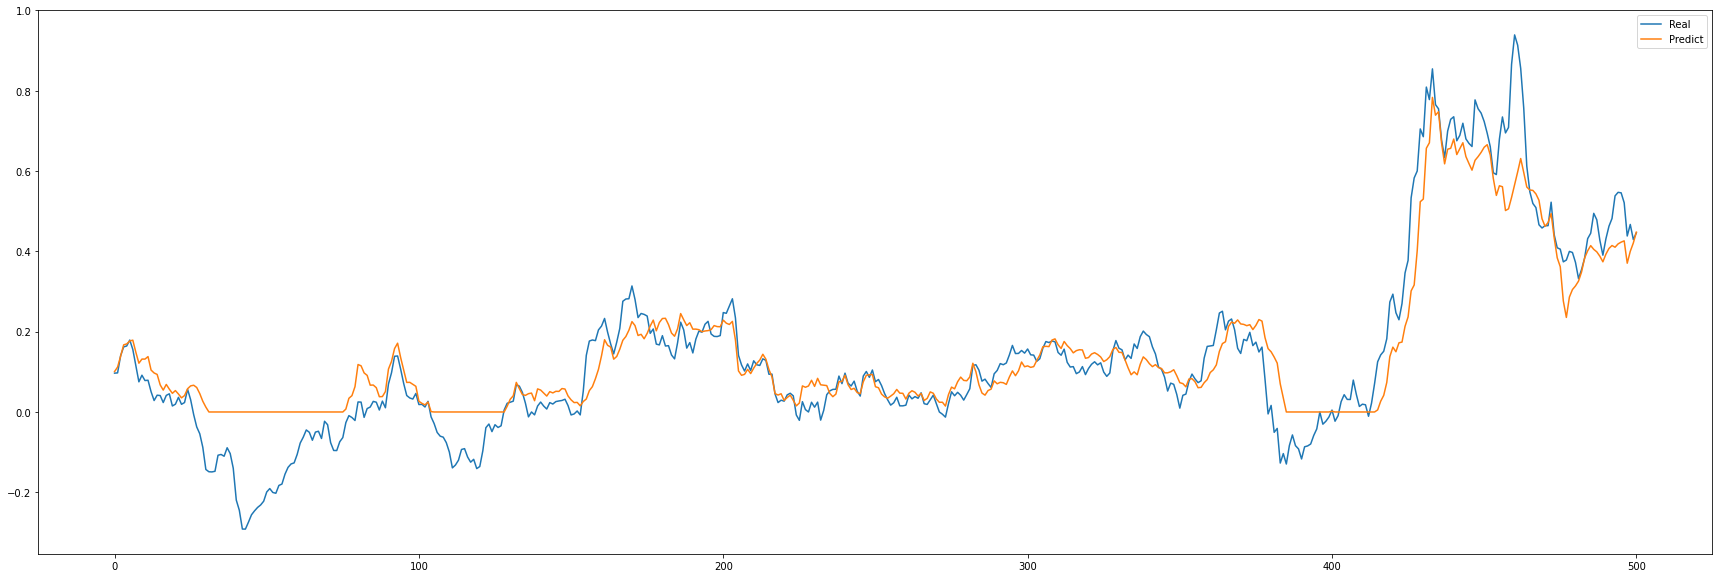

In [115]:
# 예측값과 실제값 비교
import matplotlib.pyplot as plt

plot_figure = plt.figure(figsize=(30, 10))
plot_rst = plot_figure.add_subplot(111)
plot_rst.plot(y_test, label='Real')
plot_rst.plot(pred, label='Predict')
plot_rst.legend()
plt.show()

# 2.분류 문제: Iris 붓꽃 분류

* 이 튜토리얼에서는 붓꽃을 분류하는 신경망 모델을 훈련합니다.
* 텐서플로 모델을 만들고, 훈련할 수 있는 고수준 API인 tf.keras와 사이킷런(scikit-learn)을 사용합니다.

### ✔딥러닝 목적

 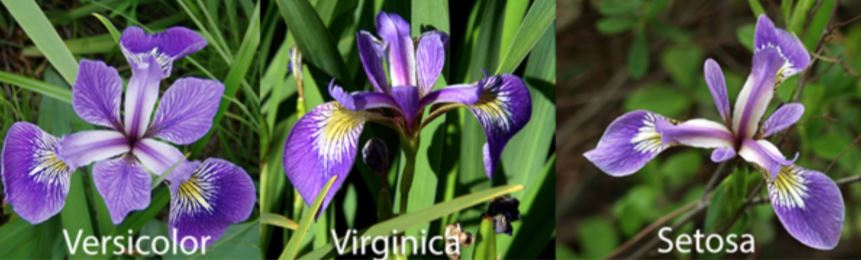
 이 프로젝트는 꽃받침과 꽃잎의 크기에 따라 붓꽃을 위 그림처럼 Setosa, Vericolor, Virginica 세 가지 다른 종으로 분류하는 모델을 구축하고 테스트합니다.

Iris 데이터 세트를 사용하여 모델을 훈련합니다. Iris 데이터 세트에는 4개의 기능과 1개의 레이블이 있습니다. 네 가지 특징은 개별 아이리스 꽃의 다음과 같은 식물 특성을 식별합니다.

* 꽃받침 길이
* 꽃받침 너비
* 꽃잎 길이
* 꽃잎 너비

### ✔데이터 읽어오기

붓꽃 데이터를 다운로드합니다.

In [ ]:
# 필요한 모듈 읽기
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
tf.compat.v1.random.set_random_seed(777)
import numpy as np

# 데이터 로드
df = pd.read_csv('https://raw.githubusercontent.com/cranberryai/todak_todak_python/master/machine_learning/multiple_classification/Iris.csv')

### ✔데이터 저장과 전처리

x_data_df에는 Id와 Species를 드롭하여 Dataframe과 분리시킵니다.

y_data_df에는 Species의 데이터만 저장합니다.

In [ ]:
x_data_df = df.drop(['Id', 'Species'], axis=1)
y_data_df = df[['Species']]

print(x_data_df.head())

   SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
0            5.1           3.5            1.4           0.2
1            4.9           3.0            1.4           0.2
2            4.7           3.2            1.3           0.2
3            4.6           3.1            1.5           0.2
4            5.0           3.6            1.4           0.2


### ✔훈련 데이터와 테스트 데이터 나누기

In [ ]:
transformer = MinMaxScaler()
transformer.fit(x_data_df)
x_data = transformer.transform(x_data_df)

lb = LabelBinarizer()
lb.fit(y_data_df)
print(lb.classes_)
labels = lb.classes_
y_data = lb.transform(y_data_df)

print(x_data.shape)
print(y_data.shape)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=777, stratify=y_data)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)) 
train_dataset = train_dataset.shuffle(buffer_size=10000)
train_dataset = train_dataset.batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)) 
test_dataset = test_dataset.batch(32)

def preprocess(x, y):
    x = x / 255

    return x, y
    
train_dataset = train_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']
(150, 4)
(150, 3)


### ✔딥러닝 모델
### ✔입력, 중간(은닉), 출력층

In [ ]:
# 모델 생성
input = tf.keras.layers.Input(shape=(4,))
net = tf.keras.layers.Dense(units=32, activation='relu')(input)
net = tf.keras.layers.Dense(units=32, activation='relu')(net)
net = tf.keras.layers.Dense(units=3, activation='softmax')(net)
model = tf.keras.models.Model(inputs=input, outputs=net)

### ✔옵티마이저, 손실함수

학습데이터의 손실과 정확도, 테스트데이터의 손실과 정확도를 출력하여 손실도가 얼마나 줄어들고 정확도가 얼마나 증가하였는지 확인할 수 있도록 했습니다.

In [ ]:
#모델 학습 및 검증
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
train_loss = tf.keras.metrics.Mean()
train_accuracy = tf.keras.metrics.Accuracy()
test_loss = tf.keras.metrics.Mean()
test_accuracy = tf.keras.metrics.Accuracy()

epochs = 50
for epoch_index in range(epochs):
    for x_train_batch, y_train_batch in train_dataset:
        with tf.GradientTape() as tape:
            predictions = model(x_train_batch, training=True)
            loss_value = loss(y_train_batch, predictions)
        gradients = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        train_loss.update_state(loss_value)
        train_accuracy.update_state(tf.argmax(y_train_batch, axis=1), tf.argmax(predictions, axis=1))

    for x_test_batch, y_test_batch in test_dataset:
        predictions = model(x_test_batch)
        loss_value = loss(y_test_batch, predictions)
        test_loss.update_state(loss_value)
        test_accuracy.update_state(tf.argmax(y_test_batch, axis=1), tf.argmax(predictions, axis=1))

    print('epoch: {}/{}, train loss: {:.4f}, test loss: {:.4f}, train accuracy: {:.4f}, test accuracy: {:.4f}'.format(
        epoch_index + 1, epochs, train_loss.result().numpy(), test_loss.result().numpy(), train_accuracy.result().numpy(), test_accuracy.result().numpy()))
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

epoch: 1/50, train loss: 1.1005, test loss: 1.0957, train accuracy: 0.3238, test accuracy: 0.3333
epoch: 2/50, train loss: 1.1013, test loss: 1.0949, train accuracy: 0.3333, test accuracy: 0.3333
epoch: 3/50, train loss: 1.1001, test loss: 1.1001, train accuracy: 0.3048, test accuracy: 0.3333
epoch: 4/50, train loss: 1.0966, test loss: 1.1000, train accuracy: 0.3333, test accuracy: 0.3333
epoch: 5/50, train loss: 1.0985, test loss: 1.0989, train accuracy: 0.3333, test accuracy: 0.3333
epoch: 6/50, train loss: 1.0971, test loss: 1.0955, train accuracy: 0.3333, test accuracy: 0.3333
epoch: 7/50, train loss: 1.1002, test loss: 1.0929, train accuracy: 0.3333, test accuracy: 0.3333
epoch: 8/50, train loss: 1.1000, test loss: 1.0901, train accuracy: 0.3333, test accuracy: 0.3333
epoch: 9/50, train loss: 1.0971, test loss: 1.0933, train accuracy: 0.3333, test accuracy: 0.3333
epoch: 10/50, train loss: 1.0957, test loss: 1.0957, train accuracy: 0.3048, test accuracy: 0.3333
epoch: 11/50, train

### ✔모델 예측

모델을 예측하여 0번에는 어떤 붓꽃의 종류가 있는지 확인합니다.

In [ ]:
#모델 예측
y_predict = model(np.array([
    [5.3, 3.7, 1.5, 0.2]
])).numpy()
print(y_predict)
print(y_predict.argmax(axis=1))
print(y_predict.argmax(axis=1)[0])
print(labels[y_predict.argmax(axis=1)[0]])

[[0. 0. 1.]]
[2]
2
Iris-virginica


# 3.CNN 문제: CIFAR-10 분류

### ✔프로젝트 목적

CIFAR-10 데이터셋은 그 유명한 2012년 ILSVRC에서 종전의 기록과 당해년도 대비 압도적인 정확도로 1등을 했던 AlexNet의 창시자 Alex krizhevsky가 수집하여 만든 데이터 셋입니다. RGB채널, 32x32 사이즈, 10개의 Class 분류 데이터 60,000개로 이루어져있습니다.

In [116]:
# 사용할 라이브러리 불러오기

import numpy as np
# 숫자 -> One-hot Vector 를 위한 라이브러리
from keras.utils import np_utils
# CIFAR-10 Dataset을 가져오기 위한 라이브러리
from keras.datasets import cifar10, mnist
# 순차적인 모델을 만들기 위한 Sequential 함수
from keras.models import Sequential
# CNN 및 MLP에 필요한 각 층들
from keras.layers import Dense, Activation
from keras.layers import Conv2D, MaxPooling2D, Flatten
# 드롭아웃 적용을 위한 층
from keras.layers import Dropout
# 배치 정규화 적용을 위한 층
from keras.layers import BatchNormalization
# L2 정규화를 위한 라이브러리
from keras.regularizers import l2
# Google Colab에서 이미지를 보기 위한 cv2_imshow 함수
from google.colab.patches import cv2_imshow

### ✔데이터 읽어오기
### ✔데이터 수, 속성 수

170500096/170498071 [==============================] - 3s 0us/step
x_train : (50000, 32, 32, 3)
y_train : (50000, 1)
x_test : (10000, 32, 32, 3)
y_test : (10000, 1)


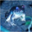

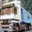

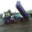

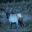

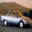

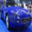

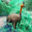

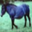

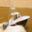

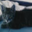

In [117]:
# CIFAR-10 Dataset 가져오기
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train :', np.shape(x_train))
print('y_train :', np.shape(y_train))
print('x_test :', np.shape(x_test))
print('y_test :', np.shape(y_test))

# 한 번 Training Dataset의 이미지 10개 정도 봅시다
for i in range(10):
  cv2_imshow(x_train[i])

### 원핫인코딩

Loss의 스케일 조정을 위해 0 ~ 255 -> 0 ~ 1 범위로 만들어줍니다.
또한, 이번엔 Test Dataset을 Validation Set으로 써봤습니다. 

In [118]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
print('y_train :', np.shape(y_train))

y_train : (50000, 10)


### ✔딥러닝 모델
### ✔입력, 중간(은닉), 출력 층, 패러미터 수
### ✔모델 종류(CNN)
### ✔모델 요약(summary)

filters : Kernel 그룹의 갯수

kernel_size : Kernel 크기

padding : 'same'일 경우 입력과 출력 모양이 같도록 0을 주변에 덧댑니다.


elu : ReLU 보다 발전된 형태의 활성화 함수입니다.

kernel_regularizer : 가중치 규제를 정해줄 수 있습니다.

l2(lambda) : 가중치의 L2 Norm을 목적 함수에 추가하며, lambda에 따라 곱해지는 상수값을 정합니다.

BatchNormalization() : 배치 정규화를 위한 층을 추가합니다.

Dropout(rate) : 앞의 층에 드롭아웃을 적용합니다. rate 값에 따라 없애고 학습할 노드 비율을 정합니다.


In [119]:
# 모델 구성하기
# 높이, 너비, 채널(RGB) 설정
width = 32
height = 32
channel = 3
# 순차적 모델을 만들기 위한 Sequential() 함수
model = Sequential(name='CIFAR10_CNN_Upgraded')
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.0001),
                 input_shape=(width, height, channel), activation='elu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.0001), activation='elu'))
model.add(BatchNormalization())
# pool_size : MaxPooling 의 Window size
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.0001), activation='elu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.0001), activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.0001), activation='elu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.0001), activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
# N차원 배열을 1차원으로 펴줍니다
model.add(Flatten())
# 출력층 MLP
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "CIFAR10_CNN_Upgraded"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64

### ✔위에서 구성한 모델 학습

loss : 목적 함수

categorical_crossentropy : 분류가 2개 이상인 CEE

optimizer : 학습 방법, Adam을 사용

metrics : 학습 도중 화면에 어떤 값을 출력할지 결정

In [120]:
# 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 학습시키기
# hist는 Epoch 당 학습 결과를 갖게 된다.
hist = model.fit(x_train, y_train,
                 epochs=30,
                 batch_size=32,
                 validation_data=(x_test, y_test))

Epoch 1/30
1563/1563 [==============================] - 454s 290ms/step - loss: 1.6532 - accuracy: 0.4931 - val_loss: 1.4285 - val_accuracy: 0.5747
Epoch 2/30
1563/1563 [==============================] - 453s 290ms/step - loss: 1.0399 - accuracy: 0.6618 - val_loss: 1.0911 - val_accuracy: 0.6545
Epoch 3/30
1563/1563 [==============================] - 455s 291ms/step - loss: 0.8889 - accuracy: 0.7160 - val_loss: 0.8994 - val_accuracy: 0.7313
Epoch 4/30
1563/1563 [==============================] - 457s 293ms/step - loss: 0.8120 - accuracy: 0.7495 - val_loss: 0.8638 - val_accuracy: 0.7478
Epoch 5/30
1563/1563 [==============================] - 457s 293ms/step - loss: 0.7587 - accuracy: 0.7752 - val_loss: 0.7622 - val_accuracy: 0.7806
Epoch 6/30
1563/1563 [==============================] - 458s 293ms/step - loss: 0.7177 - accuracy: 0.7947 - val_loss: 0.7818 - val_accuracy: 0.7839
Epoch 7/30
1563/1563 [==============================] - 459s 293ms/step - loss: 0.6983 - accuracy: 0.8070 - val_

### ✔훈련과정 시각화

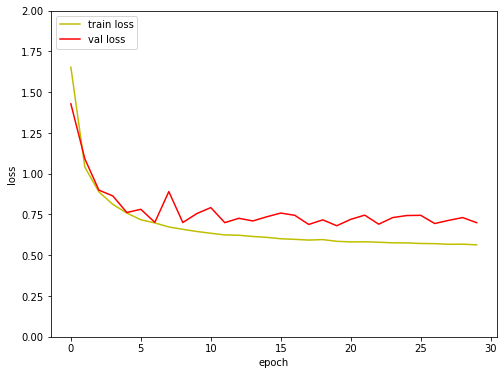

In [122]:
# 그래프를 그리기 위한 matplotlib 라이브러리
import matplotlib.pyplot as plt

# Training Loss VS Validation Loss 비교를 위한 그래프 그리기 
plt.plot(hist.history['loss'], 'y', label='train loss')
plt.plot(hist.history['val_loss'], 'r', label='val loss')

# y축 범위 설정
plt.ylim([0.0, 2.0])

# 각 축의 이름 정하기
plt.xlabel('epoch')
plt.ylabel('loss')

# 각 그래프의 설명 위치 설정 후 표시
plt.legend(loc='upper left')
plt.show()

### Test set을 통한 모델 평가

In [124]:
#모델 평가
loss_and_acc = model.evaluate(x_test, y_test, batch_size=32)
print('Test set Loss and Accuracy')
print(loss_and_acc)

313/313 [==============================] - 23s 74ms/step - loss: 0.6997 - accuracy: 0.8478
Test set Loss and Accuracy
[0.699667751789093, 0.8478000164031982]


### ✔예측 결과

예측: 고양이 / 정답: 고양이


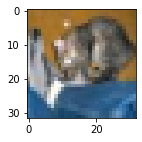

예측: 배 / 정답: 배


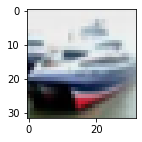

예측: 배 / 정답: 배


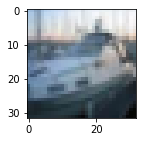

예측: 배 / 정답: 비행기


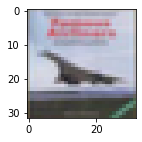

예측: 개구리 / 정답: 개구리


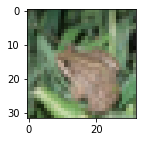

예측: 개 / 정답: 개구리


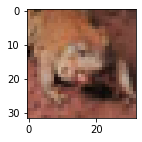

예측: 자동차 / 정답: 자동차


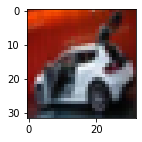

예측: 개구리 / 정답: 개구리


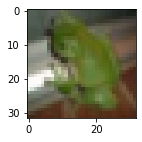

예측: 고양이 / 정답: 고양이


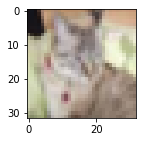

예측: 자동차 / 정답: 자동차


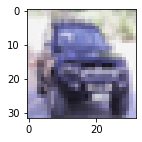

In [126]:
#모델 사용하기
# 이미지의 종류가 무엇인지에 대한 리스트
labels = ['비행기', '자동차', '새', '고양이', '사슴', '개', '개구리', '말', '배', '트럭']

# 출력 그림의 크기를 결정합니다.
plt.rcParams["figure.figsize"] = (2,2)

# Test Set의 10개를 맞추어 봅시다.
for i in range(10):
  # 모델 사용 
  output = model.predict(x_test[i].reshape(1,width, height, channel))
  
  # 이미지 출력 
  plt.imshow(x_test[i].reshape(width, height, channel))

  # np.argmax()가 labels의 인덱스가 되어 labels 배열에 있는 문자열을 출력합니다.
  print('예측: ' + labels[np.argmax(output)] + ' / 정답: ' + labels[np.argmax(y_test[i])])
  plt.show()